In [26]:
import numpy as np
from numpy import radians
from lib.cartpolesystem import CartPoleStepperMotorSystem, Cart, Pole
from lib.motors import StepperMotor
from lib.cartpoleenv import CartPoleEnv
from lib.direct_collocation import DirectCollocation, CartPoleStepperMotorDirectCollocation
from lib.controllers import LQR
from time import perf_counter
from matplotlib import pyplot as plt
from lib.numerical import rk4_step

In [27]:
dt = 0.005
g = 9.81

cart = Cart(0.1, 0.01, (-0.8, 0.8), 0.1)
motor = StepperMotor(0.06, (-10, 10), 0.2, (-2, 2), 0.1)
poles = [Pole(0.1, 0.15, 0.01), Pole(0.2, 0.2, 0.01)]
n = len(poles)

system = CartPoleStepperMotorSystem(cart, motor, poles, g)

max_time = 10
N_env = int(max_time/dt)

env = CartPoleEnv(system, dt, N_env, rk4_step)
env.observation_space.shape

(6,)

Optimizing trajectory...
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2812
Number of nonzeros in inequality constraint Jacobian.:      808
Number of nonzeros in Lagrangian Hessian.............:     1010

Total number of variables............................:      707
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      612
Total number of inequality constraints...............:      303
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      303
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.77e+00 0.00e+00  -1.0 0.00e+00

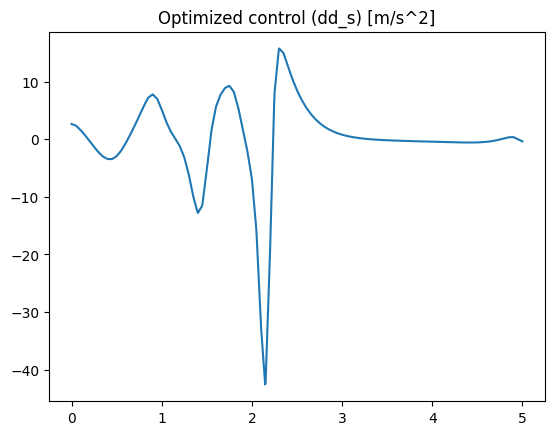

In [28]:
end_time = 5
dt_collocation = 0.05
N_collocation = int(end_time/dt_collocation)+1

N = int(end_time/dt)

direct_collocation = CartPoleStepperMotorDirectCollocation(N, N_collocation, end_time, system, 0.001)

x0 = np.array([0, 0] + [radians(180), 0]*n)

r = np.array([0, 0] + [0, 0]*n)

print("Optimizing trajectory...")
states, controls = direct_collocation.make_controller(x0, r)

time = np.linspace(0, end_time, N)

plt.title("Optimized control (dd_s) [m/s^2]")
plt.plot(time, controls.T[0])
plt.show()

In [29]:
np.set_printoptions(precision=2)

linearization_x0 = np.zeros(2+2*n)
linearization_u0 = np.array([0])

A0, B0 = direct_collocation.linearize(linearization_x0, linearization_u0)

C = np.diag([1, 1]+[1, 1]*n)

D = np.zeros((1, 1))

ct_dt = dt

lqr = LQR(ct_dt)

Q = np.diag([10, 1]+[10, 1]*n)
R = np.diag([1])

A_d0, B_d0 = lqr.discretize(A0, B0, C, D)
K_d0 = lqr.calculate_K_d(A_d0, B_d0, Q, R)

print("A:", A0)
print("B:", B0)

A: [[ 0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.   56.06 -7.62  0.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.   42.04 -2.14]]
B: [[ 0.  ]
 [ 1.  ]
 [ 0.  ]
 [-5.71]
 [ 0.  ]
 [-4.29]]


In [30]:
print("Calculating As and Bs...")
As, Bs = np.vectorize(direct_collocation.linearize, signature='(n),(m)->(n,n),(n,m)')(states, controls)

Calculating As and Bs...


In [31]:
print("Calculating A_ds and B_ds...")
A_ds, B_ds = np.vectorize(lqr.discretize, signature='(n,n),(n,m),(a,b),(c,d)->(n,n),(n,m)')(As, Bs, C, D)
print("Calculating K_ds...")
_, K_ds = lqr.calculate_finite_K_ds(A_ds, B_ds, Q, R)

Calculating A_ds and B_ds...
Calculating K_ds...


In [32]:
print("Memory usage K_ds: ", (K_ds.nbytes)/1024**1, "KB")

Memory usage K_ds:  46.875 KB


In [33]:
last_update = perf_counter()

state, _ = env.reset(x0)

errors = np.zeros((N_env, 2+2*n))
feedback_controls = np.zeros((N_env, 1))

for i in range(N_env-1):
    while perf_counter() < last_update + dt:
        pass
    last_update = perf_counter()

    error = np.zeros(2+2*n)
    if i < N*1:
        error = system.calculate_error(state, states[i])
        u_ff = controls[i]
        u_fb = lqr.feedback(K_ds[i], error)
        u = u_ff + u_fb
        feedback_controls[i] = u_fb
    else:
        error = system.calculate_error(state, states[-1])
        u = lqr.feedback(K_ds[-1], error)
    errors[i] = error

    state, reward, done, msg, _ = env.step(u)
    env.render()

env.close()

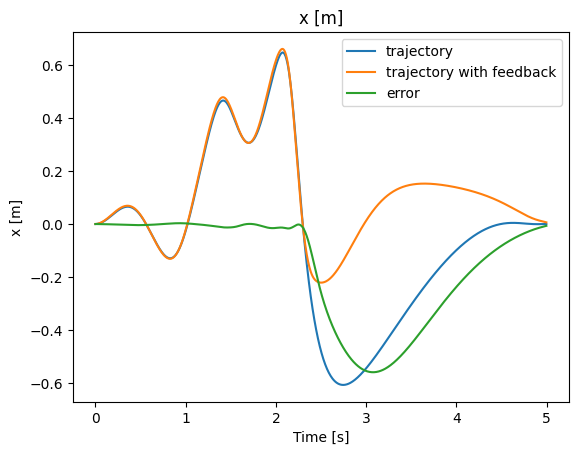

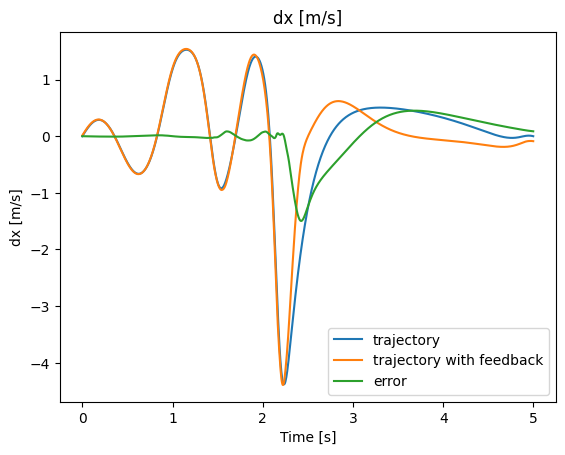

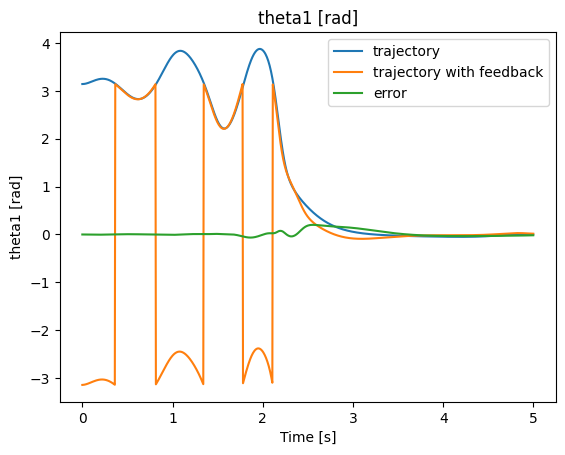

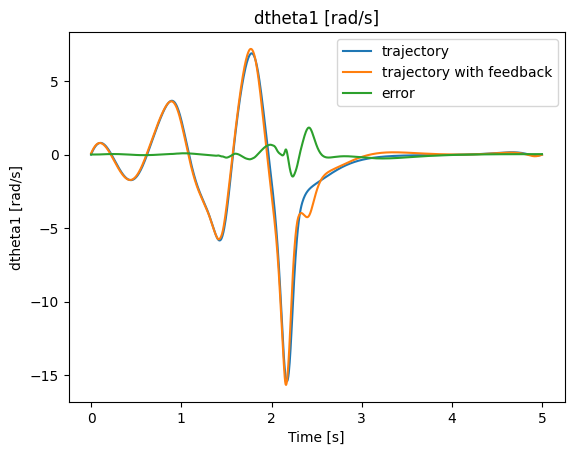

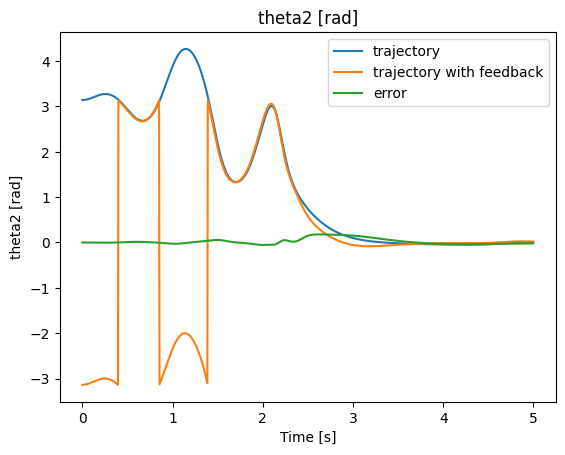

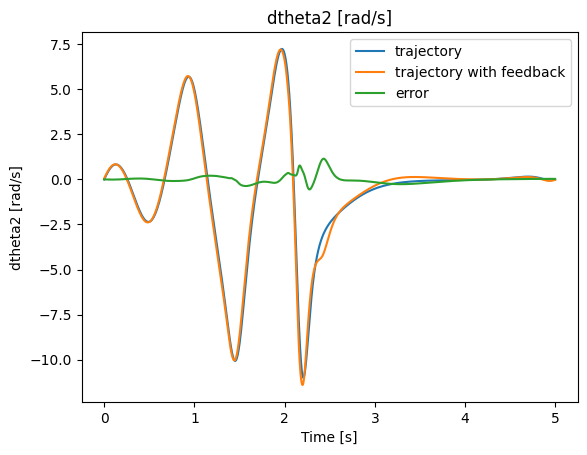

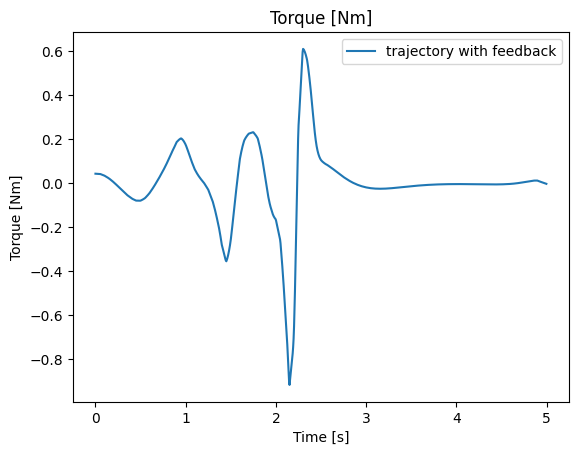

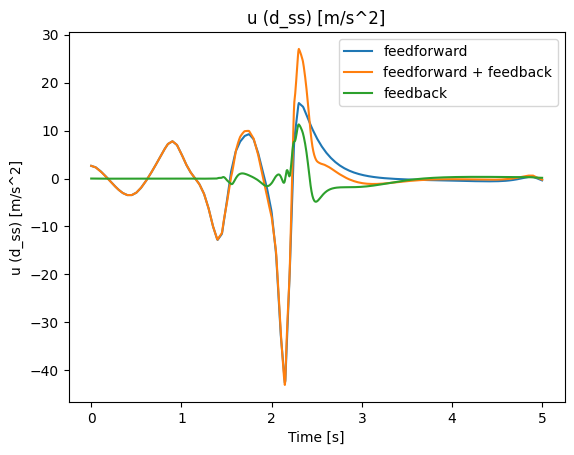

In [34]:
time = np.linspace(0, max_time, N_env)
state_labels = ["x [m]", "dx [m/s]", "theta1 [rad]", "dtheta1 [rad/s]", "theta2 [rad]", "dtheta2 [rad/s]", "theta3 [rad]", "dtheta3 [rad/s"]
for i in range(system.num_states):
    plt.xlabel("Time [s]")
    plt.ylabel(state_labels[i])
    plt.title(state_labels[i])
    plt.plot(time[:N], states.T[i][:N], label="trajectory")
    plt.plot(time[:N], env.states.T[i][1:N+1], label="trajectory with feedback")
    plt.plot(time[:N], errors.T[i][:N], label="error")
    plt.legend()
    plt.show()

constrain_labels = ["Torque [Nm]"]
for i in range(system.num_constraint_states):
    plt.xlabel("Time [s]")
    plt.ylabel(constrain_labels[i])
    plt.title(constrain_labels[i])
    plt.plot(time[:N], env.constraint_states.T[i][1:N+1], label="trajectory with feedback")
    plt.legend()
    plt.show()

plt.title("u (d_ss) [m/s^2]")
plt.xlabel("Time [s]")
plt.ylabel("u (d_ss) [m/s^2]")
plt.plot(time[:N], controls.T[0][:N], label="feedforward")
plt.plot(time[:N], env.controls.T[0][1:N+1], label="feedforward + feedback")
plt.plot(time[:N], feedback_controls.T[0][:N], label="feedback")
plt.legend()
plt.show()